## [Faces recognition example using eigenfaces and SVMs](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html)

In [1]:
import tarfile
from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC

In [2]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz 

--2023-06-07 09:02:54--  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243346528 (232M) [application/x-gzip]
Saving to: ‘lfw-funneled.tgz’

lfw-funneled.tgz    100%[===================>] 232.07M  84.1MB/s    in 2.8s    

2023-06-07 09:02:57 (84.1 MB/s) - ‘lfw-funneled.tgz’ saved [243346528/243346528]



Welcome to Labeled Faces in the Wild, a database of face photographs designed for studying the problem of unconstrained face recognition. The data set contains more than 13,000 images of faces collected from the web. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. The only constraint on these faces is that they were detected by the Viola-Jones face detector. More details can be found in the technical report below.

There are now four different sets of LFW images including the original and three different types of "aligned" images. The aligned images include "funneled images" (ICCV 2007), LFW-a, which uses an unpublished method of alignment, and "deep funneled" images (NIPS 2012). Among these, LFW-a and the deep funneled images produce superior results for most face verification algorithms over the original images and over the funneled images (ICCV 2007).

In [3]:
%%time
tfile = tarfile.open("lfw-funneled.tgz", "r:gz")
tfile.extractall(".")

CPU times: user 5.08 s, sys: 2.12 s, total: 7.2 s
Wall time: 8.05 s


In [4]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [5]:
# Download the data, if not already on disk and load it as numpy arrays
# This uses the metadata to align each image in the LFW database
# For metadata info read: 
#  https://datagen.tech/guides/image-datasets/lfw-dataset/#:~:text=Labeled%20Faces%20in%20the%20Wild%20(LFW)%20is%20an%20image%20dataset,collected%20from%20across%20the%20web.

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [6]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

In [7]:
n_samples, h, w

(1288, 50, 37)

In [8]:
# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

In [9]:
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("target y = \n", y) #target 0-6 for 7 people
print("target names = \n", target_names)

target y = 
 [5 6 3 ... 5 3 5]
target names = 
 ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


In [10]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


#### #1 Split into a training and testing set

In [11]:
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### #2 Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset)

* unsupervised feature extraction / dimensionality reduction

In [12]:
# the original dimensionality is over 1800
n_components = 150

In [13]:
print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
# create the PCA
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.416s


In [14]:
# principle components of the face data
# reshape the data so they can look like pictures
eigenfaces = pca.components_.reshape((n_components, h, w))

In [15]:
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
# transform the data into the principle component representation
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Projecting the input data on the eigenfaces orthonormal basis
done in 0.040s


#### #3 Train a SVM classification model

In [16]:
print("Fitting the classifier to the training set")
#try many hyperparameter combinations of C, gamma 
t0 = time()
param_grids = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma':  [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
}
# create the classifier
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grids)
# fit the data
clf = clf.fit(X_train_pca, y_train)

print('done in %0.3fs' % (time() - t0))
print('Best estimator found in grid search:')
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 23.440s
Best estimator found in grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


#### #4 Quantitative evaluation of the model quality on the test set

In [17]:
print("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print('done in %0.3fs' % (time() - t0))

Predicting the people names on the testing set
done in 0.072s


In [18]:
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.54      0.67        13
     Colin Powell       0.80      0.88      0.84        60
  Donald Rumsfeld       0.94      0.63      0.76        27
    George W Bush       0.85      0.98      0.91       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.91      0.83      0.87        36

         accuracy                           0.86       322
        macro avg       0.91      0.74      0.80       322
     weighted avg       0.87      0.86      0.86       322

[[  7   1   0   5   0   0   0]
 [  1  53   0   6   0   0   0]
 [  0   3  17   6   0   0   1]
 [  0   3   0 143   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   4   0   1   1   8   1]
 [  0   1   1   4   0   0  30]]


#### #5 Qualitative evaluation of the predictions using matplotlib

In [19]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

#### #6 Plot the result of the prediction on a portion of the test set

In [20]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

In [21]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

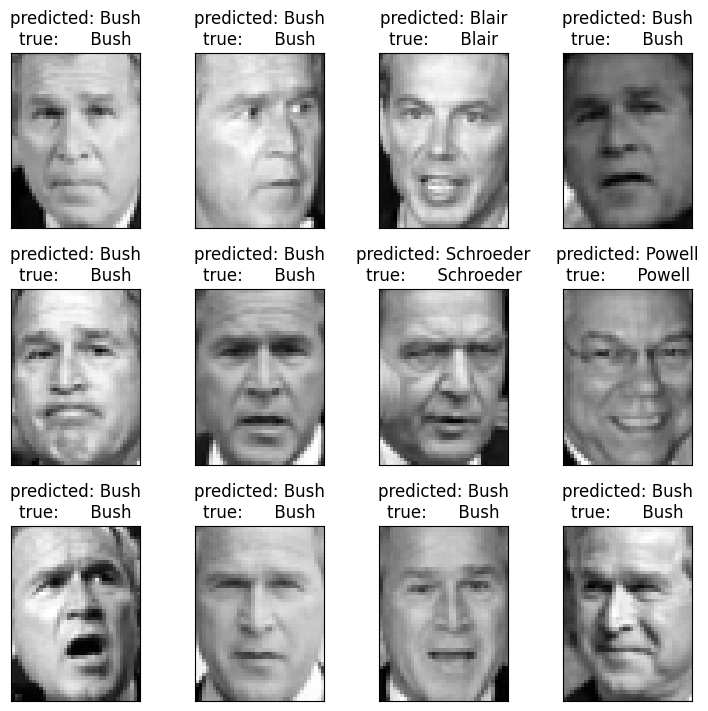

In [22]:
plot_gallery(X_test, prediction_titles, h, w)

#### #7 Plot the gallery of the most significative eigenfaces

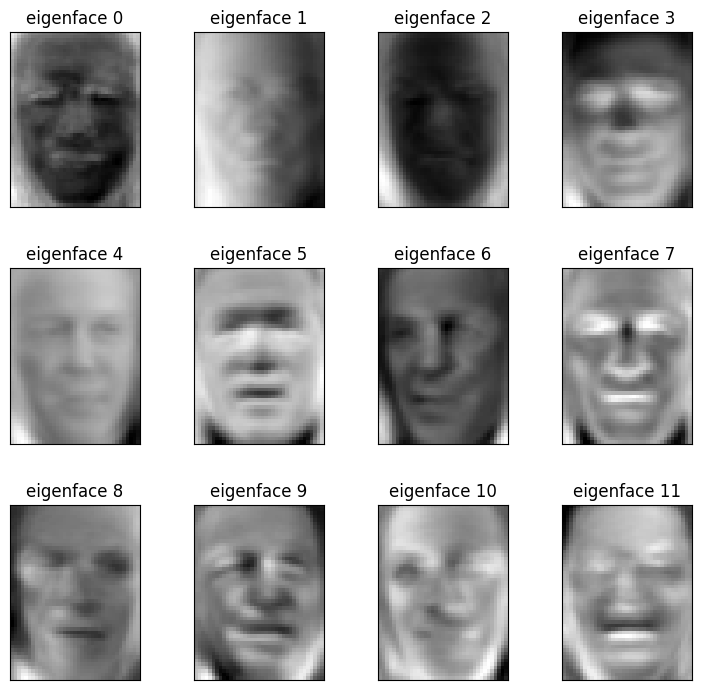

In [23]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

#### #8 How much of the variance is explained by the first principal component? The second?

In [24]:
pca.explained_variance_ratio_[0]

0.2086374

In [25]:
pca.explained_variance_ratio_[1]

0.14047948

In [26]:
print(pca.explained_variance_ratio_)

[0.2086374  0.14047948 0.06725664 0.05642477 0.04897109 0.02742939
 0.02394466 0.02115921 0.0190138  0.01804752 0.01568446 0.01506691
 0.01184343 0.01031204 0.01028612 0.00943892 0.00863882 0.00817853
 0.00801175 0.00720312 0.00673326 0.00627059 0.00623209 0.00544907
 0.00516415 0.00510547 0.00496822 0.00473948 0.00432848 0.00415507
 0.00389131 0.00385842 0.00358189 0.0034609  0.00340831 0.00328821
 0.00317629 0.00301945 0.00292283 0.00286964 0.00276701 0.0026856
 0.00261079 0.00260473 0.00245791 0.00243751 0.00240875 0.00224017
 0.00218158 0.00213791 0.00213402 0.00207676 0.00206445 0.00202878
 0.00198737 0.00188917 0.00187214 0.00185356 0.00180139 0.00178308
 0.0017109  0.00166056 0.0016242  0.00159322 0.00156874 0.00152457
 0.00148631 0.00147772 0.00146281 0.00145007 0.00140697 0.00139326
 0.00137376 0.00133275 0.00131147 0.00129434 0.0012668  0.00122819
 0.00121401 0.00121059 0.00119349 0.00118906 0.00116026 0.00115282
 0.00113847 0.00111755 0.00108684 0.00107931 0.00105445 0.00103

In [27]:
#sum up lambda's
accum = pca.explained_variance_ratio_
sum = 0.0
for i in range(pca.explained_variance_ratio_.shape[0]):
  accum[i] = sum + pca.explained_variance_ratio_[i]
  sum = accum[i]
print(accum)

[0.2086374  0.34911686 0.4163735  0.47279826 0.52176934 0.54919875
 0.5731434  0.59430265 0.6133165  0.631364   0.6470485  0.6621154
 0.67395884 0.68427086 0.69455695 0.7039959  0.7126347  0.7208132
 0.728825   0.7360281  0.7427613  0.7490319  0.755264   0.76071304
 0.7658772  0.7709827  0.7759509  0.7806904  0.78501886 0.78917396
 0.79306525 0.79692364 0.8005055  0.8039664  0.8073747  0.8106629
 0.8138392  0.81685865 0.8197815  0.82265115 0.8254182  0.8281038
 0.8307146  0.8333193  0.8357772  0.83821476 0.8406235  0.8428637
 0.84504527 0.84718317 0.8493172  0.85139394 0.8534584  0.85548717
 0.8574745  0.8593637  0.8612358  0.8630894  0.86489075 0.8666738
 0.8683847  0.8700453  0.87166953 0.87326276 0.8748315  0.87635607
 0.87784237 0.8793201  0.8807829  0.88223296 0.88363993 0.8850332
 0.88640696 0.8877397  0.8890512  0.8903455  0.8916123  0.8928405
 0.89405453 0.8952651  0.8964586  0.8976477  0.89880794 0.89996076
 0.9010992  0.90221673 0.90330356 0.9043829  0.90543735 0.9064689
 0.9

#### #9 How many PCs to use? As you add more principal components as features for training your classifier, do you expect it to get better or worse performance?

Now you'll experiment with keeping different numbers of principal components. In a multiclass classification problem like this one (more than 2 labels to apply), accuracy is a less-intuitive metric than in the 2-class case. Instead, a popular metric is the F1 score.

While ideally, adding components should provide us additional signal to improve our performance, it is possible that we end up at a complexity where we overfit.

Extracting the top 5 eigenfaces from 966 faces
done in 0.110s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.017s
Fitting the classifier to the training set
done in 340.479s
Best estimator found in grid search:
SVC(C=10000.0, class_weight='balanced', gamma=0.1)
Predicting the people names on the testing set
done in 0.018s
                   precision    recall  f1-score   support

     Ariel Sharon       0.04      0.08      0.05        13
     Colin Powell       0.32      0.32      0.32        60
  Donald Rumsfeld       0.21      0.30      0.24        27
    George W Bush       0.56      0.39      0.46       146
Gerhard Schroeder       0.17      0.20      0.18        25
      Hugo Chavez       0.05      0.07      0.06        15
       Tony Blair       0.36      0.44      0.40        36

         accuracy                           0.33       322
        macro avg       0.24      0.26      0.24       322
     weighted avg       0.39      0.33      0.35       322


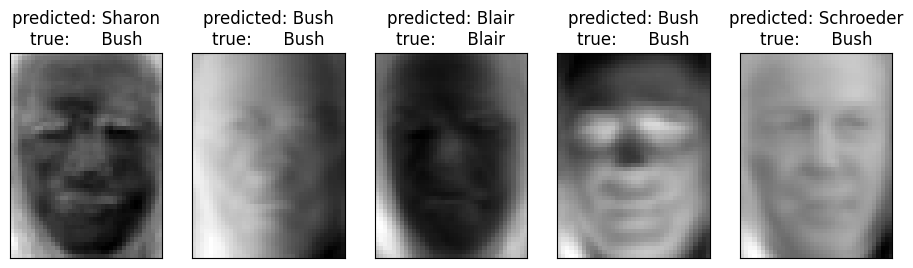

Extracting the top 9 eigenfaces from 966 faces
done in 0.142s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s
Fitting the classifier to the training set
done in 178.637s
Best estimator found in grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.1)
Predicting the people names on the testing set
done in 0.020s
                   precision    recall  f1-score   support

     Ariel Sharon       0.12      0.23      0.16        13
     Colin Powell       0.47      0.58      0.52        60
  Donald Rumsfeld       0.33      0.41      0.37        27
    George W Bush       0.69      0.57      0.62       146
Gerhard Schroeder       0.12      0.12      0.12        25
      Hugo Chavez       0.21      0.20      0.21        15
       Tony Blair       0.40      0.33      0.36        36

         accuracy                           0.47       322
        macro avg       0.34      0.35      0.34       322
     weighted avg       0.50      0.47      0.48       322



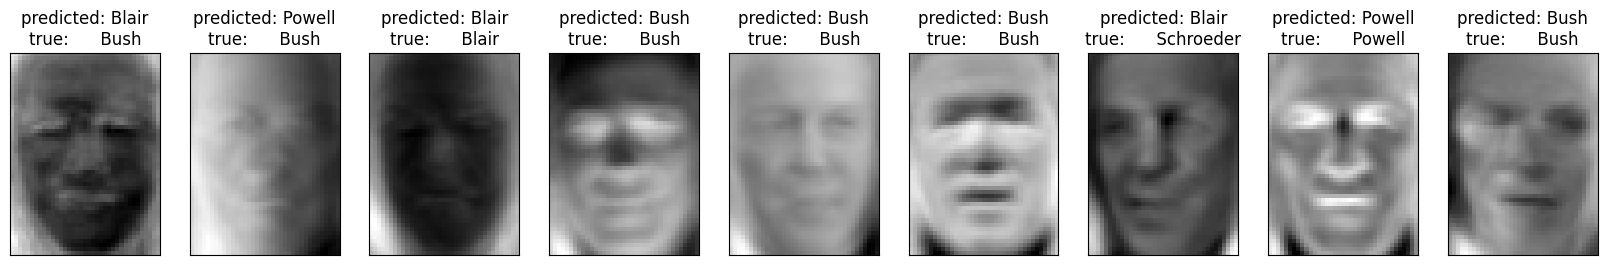

Extracting the top 16 eigenfaces from 966 faces
done in 0.167s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.022s
Fitting the classifier to the training set
done in 31.502s
Best estimator found in grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)
Predicting the people names on the testing set
done in 0.015s
                   precision    recall  f1-score   support

     Ariel Sharon       0.20      0.23      0.21        13
     Colin Powell       0.61      0.77      0.68        60
  Donald Rumsfeld       0.35      0.44      0.39        27
    George W Bush       0.76      0.66      0.71       146
Gerhard Schroeder       0.44      0.44      0.44        25
      Hugo Chavez       0.50      0.40      0.44        15
       Tony Blair       0.53      0.50      0.51        36

         accuracy                           0.60       322
        macro avg       0.49      0.49      0.49       322
     weighted avg       0.61      0.60      0.60       322

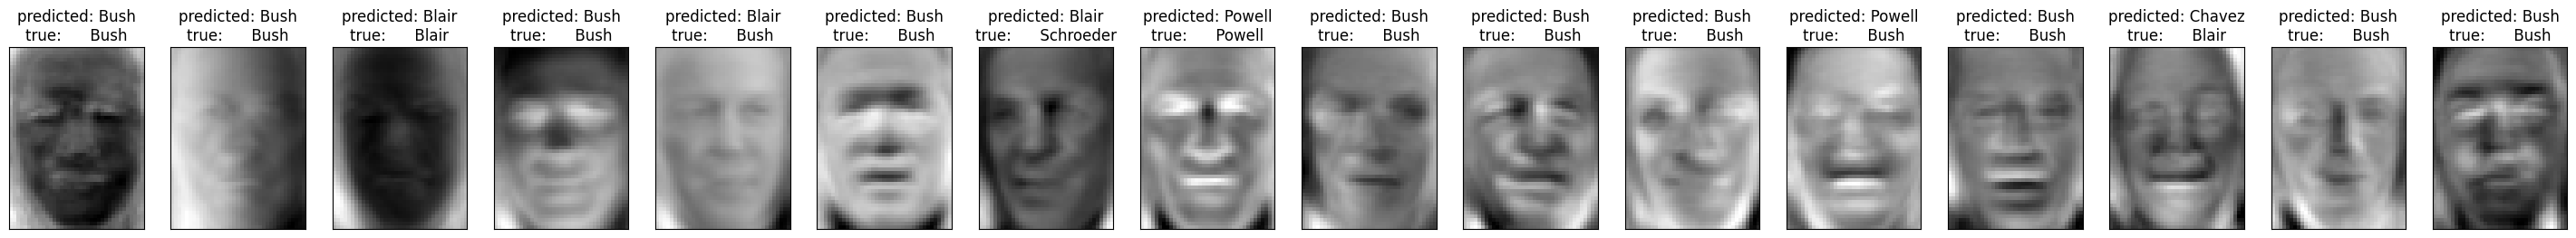

Extracting the top 33 eigenfaces from 966 faces
done in 0.238s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.018s
Fitting the classifier to the training set
done in 13.532s
Best estimator found in grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.01)
Predicting the people names on the testing set
done in 0.018s
                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.62      0.55        13
     Colin Powell       0.65      0.82      0.73        60
  Donald Rumsfeld       0.62      0.56      0.59        27
    George W Bush       0.87      0.82      0.85       146
Gerhard Schroeder       0.60      0.60      0.60        25
      Hugo Chavez       0.67      0.67      0.67        15
       Tony Blair       0.76      0.61      0.68        36

         accuracy                           0.74       322
        macro avg       0.67      0.67      0.66       322
     weighted avg       0.75      0.74      0.74       322


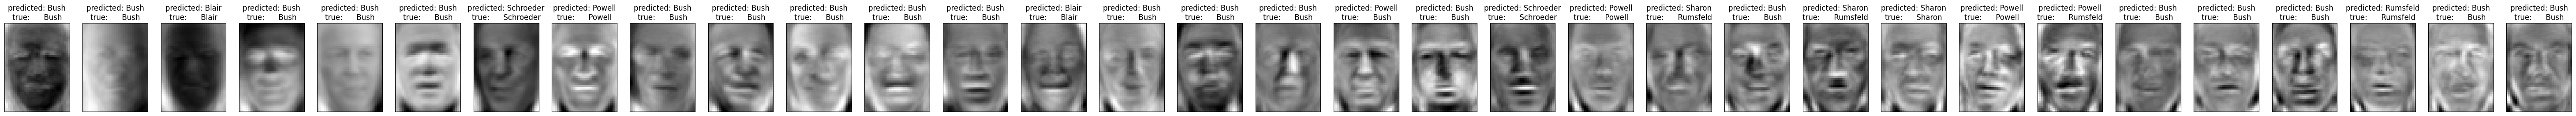

Extracting the top 85 eigenfaces from 966 faces
done in 0.342s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.016s
Fitting the classifier to the training set
done in 16.665s
Best estimator found in grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.01)
Predicting the people names on the testing set
done in 0.040s
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.69      0.82        13
     Colin Powell       0.88      0.93      0.90        60
  Donald Rumsfeld       0.90      0.70      0.79        27
    George W Bush       0.85      0.97      0.90       146
Gerhard Schroeder       0.85      0.68      0.76        25
      Hugo Chavez       1.00      0.67      0.80        15
       Tony Blair       0.83      0.69      0.76        36

         accuracy                           0.86       322
        macro avg       0.90      0.76      0.82       322
     weighted avg       0.87      0.86      0.86       322


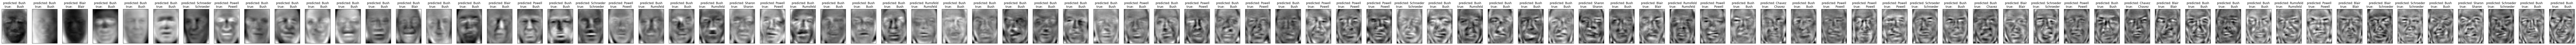

Extracting the top 1 eigenfaces from 966 faces
done in 0.232s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.014s
Fitting the classifier to the training set
done in 80.116s
Best estimator found in grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.1)
Predicting the people names on the testing set
done in 0.018s
                   precision    recall  f1-score   support

     Ariel Sharon       0.17      0.08      0.11        13
     Colin Powell       0.19      0.20      0.19        60
  Donald Rumsfeld       0.00      0.00      0.00        27
    George W Bush       0.38      0.10      0.15       146
Gerhard Schroeder       0.23      0.12      0.16        25
      Hugo Chavez       0.08      0.40      0.13        15
       Tony Blair       0.16      0.56      0.25        36

         accuracy                           0.17       322
        macro avg       0.17      0.21      0.14       322
     weighted avg       0.25      0.17      0.16       322

[

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

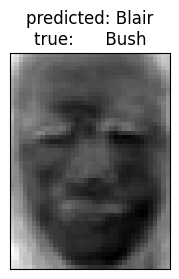

In [28]:
# the original dimensionality is over 1800
# n_components = 150

# change to n_components for 50%, 60%, 70%, 80%, 90%, 95%
preserved_variances = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
for preserved_variance in preserved_variances:
    n_components = np.argmax(accum >= preserved_variance) + 1
    print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
    t0 = time()
    pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
    print("done in %0.3fs" % (time() - t0))

    # principle components of the face data
    eigenfaces = pca.components_.reshape((n_components, h, w))

    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("done in %0.3fs" % (time() - t0))

    print("Fitting the classifier to the training set")
    t0 = time()
    param_grids = {
        'C': [1e3, 5e3, 1e4, 5e4, 1e5],
        'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
    }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grids)
    clf = clf.fit(X_train_pca, y_train)

    print('done in %0.3fs' % (time() - t0))
    print('Best estimator found in grid search:')
    print(clf.best_estimator_)

    print("Predicting the people names on the testing set")
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print('done in %0.3fs' % (time() - t0))

    print(classification_report(y_test, y_pred, target_names=target_names))
    print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

    f1_scores = classification_report(y_test, y_pred, output_dict=True)['macro avg']
    macro_avg_f1 = f1_scores['f1-score']
    print(f"Macro-average F1 score for {preserved_variance * 100}% variance preserved: {macro_avg_f1}\n")

    prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]

    plot_gallery(eigenfaces, prediction_titles, h, w, n_row=1, n_col=n_components)
    pl.show()


#### #10 If you see a higher F1 score, does it mean the classifier is doing better, or worse?

Yes, higher means better!

#### #11 Do you see any evidence of overfitting when using a large number of PCs? Does the dimensionality reduction of PCA seem to be helping your performance here?

Yes, the F1 score starts to drop.

#### #12 Selecting a Number of Principal Components 

* train on different number of PCs and see how accuracy responds - cut off when it comes apparent that adding more PCs doesn't buy you more discrimination.

* this can be done also in feature selection as well. You don't want to do feature selection before going into PCA. PCA is going to combine information from potentially many different input features together